In [1]:
####### importing all required packages here ##########
import numpy as np
import random
import time
import matplotlib.pyplot as plt

In [2]:
###### Fucntion for creating random adjacency matrix. #########

def create_adjacency_matrix(number_of_vertices, probability):
    adj_matrix = np.ones((number_of_vertices,number_of_vertices))
    for i in range(0,number_of_vertices):
        for j in range(0,number_of_vertices):
            if random.random()>probability:
                adj_matrix[i,j]=0

    return adj_matrix

In [3]:
###### Function for converting binary number to decimal #######

def dec_to_bin(decimal, no_bits):
    binary = np.zeros((no_bits))
    for i in range(no_bits-1,-1,-1):
        #print(decimal, i)
        if int(decimal/(2**i)):
            binary[i]=1
        decimal = decimal%(2**i)
    
    return binary

In [4]:
####### Using Brute force ########

def brute_force(n, adj_matrix):
    best_cost = 0
    best_case = None
    for k in range(2**n):
        binary_k=dec_to_bin(k, n)
        temp_cost = 0
        for i in range(n):
            for j in range(n):
                temp_cost = temp_cost + adj_matrix[i,j]*binary_k[i]*(1-binary_k[j])
        if temp_cost > best_cost:
            best_cost = temp_cost
            best_case = binary_k

    return best_cost

In [9]:
def get_cost_and_time_vs_n(n1, n2):
    cost_vs_n = list()
    time_vs_n = list()
    cost = list()
    tim = list()
    for j in range(n1,n2):
        for i in range(5):
            initial_time = time.time()
            cost.append(brute_force(j, create_adjacency_matrix(j, 0.5)))
            final_time = time.time()
            tim.append(final_time - initial_time)
        average_cost = sum(cost)/5
        average_time = sum(tim)/5 
        (x, y) = (j, average_cost)
        (x, z) = (j, average_time)
        cost_vs_n.append((x, y))
        time_vs_n.append((x, z))
        print(x,  y,  z)
        cost.clear()
        time.clear()
    return cost_vs_n, time_vs_n


4 3.2 0.000997304916381836
5 4.6 0.003168201446533203
6 6.4 0.008753204345703125
7 8.4 0.01912527084350586
8 11.8 0.050507640838623045
9 14.8 0.1101747989654541
10 18.6 0.2597806453704834
11 21.0 0.6060098648071289
12 24.8 1.3237273216247558
13 31.2 3.0678380012512205
14 33.0 6.622115802764893
15 39.2 14.618809080123901
16 45.2 32.88604989051819
17 49.4 74.34144110679627
18 53.6 168.73394870758057
19 59.8 354.1896758556366
20 65.6 702.745646238327


KeyboardInterrupt: 

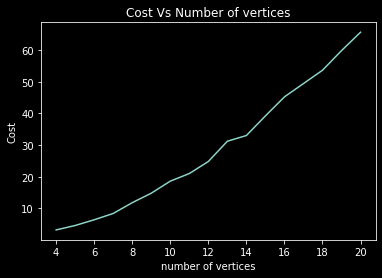

In [10]:
#### plotting cost vs n #####
plt.title("Cost Vs Number of vertices")
plt.ylabel('Cost')
plt.xlabel('number of vertices')
x, y = zip(*cost_vs_n)
plt.plot(x, y)

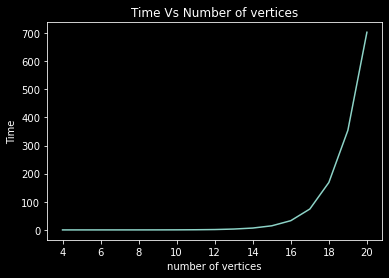

In [11]:
plt.title("Time Vs Number of vertices")
plt.ylabel('Time')
plt.xlabel('number of vertices')
x, y = zip(*time_vs_n)
plt.plot(x, y)